# Segmentation avec KMeans

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

raw_datas = pd.read_csv("POLIST_11_raw_datas.csv")
raw_datas

,order_id,customer_unique_id,customer_state,delivering_time,delivered_before_time,nb_score,score_mean,init_score,diff_score,purchase_date,purchase_y_m,purchase_y_q,purchase_y_s,purchase_y,days_last_purchase,pay_sum,installments_min,installments_max,installments_mean,installments_size,type_boleto,type_credit_card,type_debit_card,type_voucher,price_min,price_mean,price_max,price_sum,freight_value_min,freight_value_mean,freight_value_max,freight_value_sum,product_description_lenght_mean,product_photos_qty_mean,weight_min,weight_mean,weight_max,nb_product_min,nb_product_mean,nb_product_max,nb_product_sum,category__agro_industry_and_commerce,category__air_conditioning,category__art,category__arts_and_craftmanship,category__audio,category__auto,category__baby,category__bed_bath_table,category__books_general_interest,category__books_imported,category__books_technical,category__cds_dvds_musicals,category__christmas_supplies,category__cine_photo,category__computers,category__computers_accessories,category__consoles_games,category__construction_tools_construction,category__construction_tools_lights,category__construction_tools_safety,category__cool_stuff,category__costruction_tools_garden,category__costruction_tools_tools,category__diapers_and_hygiene,category__drinks,category__dvds_blu_ray,category__electronics,category__fashio_female_clothing,category__fashion_bags_accessories,category__fashion_childrens_clothes,category__fashion_male_clothing,category__fashion_shoes,category__fashion_sport,category__fashion_underwear_beach,category__fixed_telephony,category__flowers,category__food,category__food_drink,category__furniture_bedroom,category__furniture_decor,category__furniture_living_room,category__furniture_mattress_and_upholstery,category__garden_tools,category__health_beauty,category__home_appliances,category__home_appliances_2,category__home_comfort_2,category__home_confort,category__home_construction,category__housewares,category__industry_commerce_and_business,category__kitchen_dining_laundry_garden_furniture,category__kitchen_laptops_and_food_preparers,category__la_cuisine,category__luggage_accessories,category__market_place,category__music,category__musical_instruments,category__office_furniture,category__others,category__party_supplies,category__pc_gamer,category__perfumery,category__pet_shop,category__security_and_services,category__signaling_and_security,category__small_appliances,category__small_appliances_home_oven_and_coffee,category__sports_leisure,category__stationery,category__tablets_printing_image,category__telephony,category__toys,category__watches_gifts,seller_state__AC,seller_state__AM,seller_state__BA,seller_state__CE,seller_state__DF,seller_state__ES,seller_state__GO,seller_state__MA,seller_state__MG,seller_state__MS,seller_state__MT,seller_state__PA,seller_state__PB,seller_state__PE,seller_state__PI,seller_state__PR,seller_state__RJ,seller_state__RN,seller_state__RO,seller_state__RS,seller_state__SC,seller_state__SE,seller_state__SP
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,SP,8.0,True,1,4.0,4,0,2017-10-02,201710,20174,20172,2017,331,38.71,1,1,1.0,3,0.0,1.0,0.0,2.0,29.99,29.99,29.99,29.99,8.72,8.72,8.72,8.72,268.0,4.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,BA,12.0,True,1,4.0,4,0,2018-07-24,201807,20183,20182,2018,36,141.46,1,1,1.0,1,1.0,0.0,0.0,0.0,118.70,118.70,118.70,118.70,22.76,22.76,22.76,22.76,178.0,1.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Grouper les données
En premier lieu, il faut grouper le jeu de données par client, ces derniers étant notre cible.

Pour donner forme au jeu de données, je vais effectuer différentes actions en fonction des features:
* Somme:
  * "category__*", "type_*" et "seller_state__*" encodés
  * ~~features associées à une somme~~
  * "installments_size"
  * "nb_score" donnés
  * "pay_sum"
  * "nb_product_sum"
* Min:
  * ~~features associées à une valeur min~~
  * "days_last_purchase"
  * min de "pay_sum"
  * "installments_min"
  * "nb_product_min"
* Max:
  * ~~features associées à une valeur max~~
  * max de "pay_sum"
  * "installments_max"
  * "nb_product_max"
* Mean:
  * ~~features associées à une moyenne~~
  * Moyenne des scores initiaux "init_score" et de leurs évolutions "diff_score"
  * "delivering_time"
  * "delivered_before_time"
  * moy de "pay_sum"
  * "installments_mean"
  * "product_description_lenght_mean"
  * "product_photos_qty_mean"
  * "nb_product_mean"
* Size:
  * nombre d'achat sur toute la durée (fréquence)

***Par contre, j'ai vu précédemment qu'il y a 36 changements d'états parmis les clients. Je vais garder le dernier état de résidence en date.***

In [2]:
# list_states = []
# for id in raw_datas["customer_unique_id"].unique():
#     min_day = raw_datas.loc[raw_datas["customer_unique_id"] == id, "days_last_purchase"].min()
#     state = raw_datas.loc[(raw_datas["customer_unique_id"] == id) & (raw_datas["days_last_purchase"] == min_day), 
#         "customer_state"].values[0]
    
#     list_states.append([id, state])

# tmp_states = pd.DataFrame(list_states, columns=["customer_unique_id", "customer_state"])

# tmp_states.to_csv("POLIST_13_tmp_states.csv", index= False)

In [3]:
tmp_states = pd.read_csv("POLIST_13_tmp_states.csv")

tmp_states

,customer_unique_id,customer_state
0,7c396fd4830fd04220f754e42b4e5bff,SP
1,af07308b275d755c9edb36a90c618231,BA
2,3a653a41f6f9fc3d2a113cf8398680e8,GO
3,7c142cf63193a1473d2e66489a9ae977,RN
4,72632f0f9dd73dfee390c9b22eb56dd6,SP
...,...,...
92826,6359f309b166b0196dbf7ad2ac62bb5a,SP
92827,da62f9e57a76d978d02ab5362c509660,SP
92828,737520a9aad80b3fbbdad19b66b37b30,BA
92829,5097a5312c8b157bb7be58ae360ef43c,RJ


In [4]:
# from sklearn.preprocessing import OneHotEncoder

# X = raw_datas["customer_state"].to_numpy().reshape(-1, 1)

# ohe = OneHotEncoder().fit(X)
# state_ohe = pd.DataFrame(ohe.transform(X).toarray(), columns= ohe.get_feature_names_out(["customer_state__"]), index= raw_datas.index)

# raw_datas.drop("customer_state", axis= 1, inplace=True)
# raw_datas = raw_datas.merge(state_ohe, left_index=True, right_index= True)

In [5]:
def cols_rename(data, name):
    rename_cols = {}
    for col in data.columns[1:]:
        rename_cols[col] = col + "_" + name

    return data.rename(rename_cols, axis= 1)

In [6]:
import re

sum_cols = ["nb_score", "pay_sum", "nb_product_sum"] # "installments_size", 

for col in raw_datas.columns:
    if re.search(r"^category__.*", col) is not None:
        sum_cols.append(col)
    elif re.search(r"^type_.*", col) is not None:
        sum_cols.append(col)
    elif re.search(r"^seller_state__.*", col) is not None:
        sum_cols.append(col)
    # elif re.search(r"^customer_state__.*", col) is not None:
    #     sum_cols.append(col)

tmp_sum = raw_datas.groupby("customer_unique_id")[sum_cols].sum().reset_index()
tmp_sum = cols_rename(tmp_sum, "sum")

tmp_sum

,customer_unique_id,nb_score_sum,pay_sum_sum,nb_product_sum_sum,type_boleto_sum,type_credit_card_sum,type_debit_card_sum,type_voucher_sum,category__agro_industry_and_commerce_sum,category__air_conditioning_sum,category__art_sum,category__arts_and_craftmanship_sum,category__audio_sum,category__auto_sum,category__baby_sum,category__bed_bath_table_sum,category__books_general_interest_sum,category__books_imported_sum,category__books_technical_sum,category__cds_dvds_musicals_sum,category__christmas_supplies_sum,category__cine_photo_sum,category__computers_sum,category__computers_accessories_sum,category__consoles_games_sum,category__construction_tools_construction_sum,category__construction_tools_lights_sum,category__construction_tools_safety_sum,category__cool_stuff_sum,category__costruction_tools_garden_sum,category__costruction_tools_tools_sum,category__diapers_and_hygiene_sum,category__drinks_sum,category__dvds_blu_ray_sum,category__electronics_sum,category__fashio_female_clothing_sum,category__fashion_bags_accessories_sum,category__fashion_childrens_clothes_sum,category__fashion_male_clothing_sum,category__fashion_shoes_sum,category__fashion_sport_sum,category__fashion_underwear_beach_sum,category__fixed_telephony_sum,category__flowers_sum,category__food_sum,category__food_drink_sum,category__furniture_bedroom_sum,category__furniture_decor_sum,category__furniture_living_room_sum,category__furniture_mattress_and_upholstery_sum,category__garden_tools_sum,category__health_beauty_sum,category__home_appliances_sum,category__home_appliances_2_sum,category__home_comfort_2_sum,category__home_confort_sum,category__home_construction_sum,category__housewares_sum,category__industry_commerce_and_business_sum,category__kitchen_dining_laundry_garden_furniture_sum,category__kitchen_laptops_and_food_preparers_sum,category__la_cuisine_sum,category__luggage_accessories_sum,category__market_place_sum,category__music_sum,category__musical_instruments_sum,category__office_furniture_sum,category__others_sum,category__party_supplies_sum,category__pc_gamer_sum,category__perfumery_sum,category__pet_shop_sum,category__security_and_services_sum,category__signaling_and_security_sum,category__small_appliances_sum,category__small_appliances_home_oven_and_coffee_sum,category__sports_leisure_sum,category__stationery_sum,category__tablets_printing_image_sum,category__telephony_sum,category__toys_sum,category__watches_gifts_sum,seller_state__AC_sum,seller_state__AM_sum,seller_state__BA_sum,seller_state__CE_sum,seller_state__DF_sum,seller_state__ES_sum,seller_state__GO_sum,seller_state__MA_sum,seller_state__MG_sum,seller_state__MS_sum,seller_state__MT_sum,seller_state__PA_sum,seller_state__PB_sum,seller_state__PE_sum,seller_state__PI_sum,seller_state__PR_sum,seller_state__RJ_sum,seller_state__RN_sum,seller_state__RO_sum,seller_state__RS_sum,seller_state__SC_sum,seller_state__SE_sum,seller_state__SP_sum
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0000f46a3911fa3c0805444483337064,1,86.22,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [7]:
min_cols = ["days_last_purchase"] # , "pay_sum", "installments_min", "nb_product_min"

tmp_min = raw_datas.groupby("customer_unique_id")[min_cols].min().reset_index()
tmp_min = cols_rename(tmp_min, "min")
tmp_min

,customer_unique_id,days_last_purchase_min
0,0000366f3b9a7992bf8c76cfdf3221e2,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114
2,0000f46a3911fa3c0805444483337064,537
3,0000f6ccb0745a6a4b88665a16c9f078,321
4,0004aac84e0df4da2b147fca70cf8255,288
...,...,...
92826,fffcf5a5ff07b0908bd4e2dbc735a684,447
92827,fffea47cd6d3cc0a88bd621562a9d061,262
92828,ffff371b4d645b6ecea244b27531430a,568
92829,ffff5962728ec6157033ef9805bacc48,119


In [8]:
freq_datas = raw_datas.groupby("customer_unique_id", as_index= False)["order_id"].count()
freq_datas.rename({"order_id": "frequency"}, axis= 1, inplace= True)
freq_datas

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
92826,fffcf5a5ff07b0908bd4e2dbc735a684,1
92827,fffea47cd6d3cc0a88bd621562a9d061,1
92828,ffff371b4d645b6ecea244b27531430a,1
92829,ffff5962728ec6157033ef9805bacc48,1


In [9]:
# max_cols = ["pay_sum", "installments_max", "nb_product_max"]

# tmp_max = raw_datas.groupby("customer_unique_id")[max_cols].max().reset_index()
# tmp_max.rename({"pay_sum": "pay_max"}, axis= 1, inplace= True)
# tmp_max

In [10]:
mean_cols = ["init_score", "delivering_time"] # ["init_score", "diff_score", "delivering_time", "delivered_before_time", "pay_sum", "installments_mean", 
    # "product_description_lenght_mean", "product_photos_qty_mean", "nb_product_mean"]

tmp_mean = raw_datas.groupby("customer_unique_id")[mean_cols].mean().reset_index()
tmp_mean = cols_rename(tmp_mean, "mean")

tmp_mean

,customer_unique_id,init_score_mean,delivering_time_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,2.0
2,0000f46a3911fa3c0805444483337064,3.0,25.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,20.0
4,0004aac84e0df4da2b147fca70cf8255,5.0,13.0
...,...,...,...
92826,fffcf5a5ff07b0908bd4e2dbc735a684,5.0,27.0
92827,fffea47cd6d3cc0a88bd621562a9d061,4.0,30.0
92828,ffff371b4d645b6ecea244b27531430a,5.0,14.0
92829,ffff5962728ec6157033ef9805bacc48,5.0,11.0


In [11]:
datas = tmp_states.merge(tmp_sum.merge(tmp_min, on="customer_unique_id"), on="customer_unique_id")
datas = datas.merge(freq_datas.merge(tmp_mean, on="customer_unique_id"), on= "customer_unique_id")

# var = "customer_unique_id"
# datas = tmp_sum.merge(tmp_min.merge(tmp_max.merge(tmp_mean, on= var), on= var
#     ), on= var)

datas

,customer_unique_id,customer_state,nb_score_sum,pay_sum_sum,nb_product_sum_sum,type_boleto_sum,type_credit_card_sum,type_debit_card_sum,type_voucher_sum,category__agro_industry_and_commerce_sum,category__air_conditioning_sum,category__art_sum,category__arts_and_craftmanship_sum,category__audio_sum,category__auto_sum,category__baby_sum,category__bed_bath_table_sum,category__books_general_interest_sum,category__books_imported_sum,category__books_technical_sum,category__cds_dvds_musicals_sum,category__christmas_supplies_sum,category__cine_photo_sum,category__computers_sum,category__computers_accessories_sum,category__consoles_games_sum,category__construction_tools_construction_sum,category__construction_tools_lights_sum,category__construction_tools_safety_sum,category__cool_stuff_sum,category__costruction_tools_garden_sum,category__costruction_tools_tools_sum,category__diapers_and_hygiene_sum,category__drinks_sum,category__dvds_blu_ray_sum,category__electronics_sum,category__fashio_female_clothing_sum,category__fashion_bags_accessories_sum,category__fashion_childrens_clothes_sum,category__fashion_male_clothing_sum,category__fashion_shoes_sum,category__fashion_sport_sum,category__fashion_underwear_beach_sum,category__fixed_telephony_sum,category__flowers_sum,category__food_sum,category__food_drink_sum,category__furniture_bedroom_sum,category__furniture_decor_sum,category__furniture_living_room_sum,category__furniture_mattress_and_upholstery_sum,category__garden_tools_sum,category__health_beauty_sum,category__home_appliances_sum,category__home_appliances_2_sum,category__home_comfort_2_sum,category__home_confort_sum,category__home_construction_sum,category__housewares_sum,category__industry_commerce_and_business_sum,category__kitchen_dining_laundry_garden_furniture_sum,category__kitchen_laptops_and_food_preparers_sum,category__la_cuisine_sum,category__luggage_accessories_sum,category__market_place_sum,category__music_sum,category__musical_instruments_sum,category__office_furniture_sum,category__others_sum,category__party_supplies_sum,category__pc_gamer_sum,category__perfumery_sum,category__pet_shop_sum,category__security_and_services_sum,category__signaling_and_security_sum,category__small_appliances_sum,category__small_appliances_home_oven_and_coffee_sum,category__sports_leisure_sum,category__stationery_sum,category__tablets_printing_image_sum,category__telephony_sum,category__toys_sum,category__watches_gifts_sum,seller_state__AC_sum,seller_state__AM_sum,seller_state__BA_sum,seller_state__CE_sum,seller_state__DF_sum,seller_state__ES_sum,seller_state__GO_sum,seller_state__MA_sum,seller_state__MG_sum,seller_state__MS_sum,seller_state__MT_sum,seller_state__PA_sum,seller_state__PB_sum,seller_state__PE_sum,seller_state__PI_sum,seller_state__PR_sum,seller_state__RJ_sum,seller_state__RN_sum,seller_state__RO_sum,seller_state__RS_sum,seller_state__SC_sum,seller_state__SE_sum,seller_state__SP_sum,days_last_purchase_min,frequency,init_score_mean,delivering_time_mean
0,7c396fd4830fd04220f754e42b4e5bff,SP,2,82.82,2,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,331,2,4.5,4.5
1,af07308b275d755c9edb36a90c618231,BA,1,141.46,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36,1,4.0,12.0
2,3a653a41f6f9fc3d2a113cf8398680e8,GO,1,179.12,1,0.0,1.0,0.0,0

In [12]:
# datas.to_csv("POLIST_13_gpb_datas.csv", index=False)

### KMeans

Il faut encoder les features avant le KMeans.

Vérifions d'abord la présence de valeurs nulles.

In [13]:
for col in datas.columns:
    nb_null = datas[col].isnull().sum()
    if nb_null > 0:
        print(f"{col} => {nb_null}")

delivering_time_mean => 21


In [14]:
print(f"Valeur max: {datas['delivering_time_mean'].max()}")
print(f"Valeur min: {datas['delivering_time_mean'].min()}")

Valeur max: 208.0
Valeur min: -7.0


In [15]:
print(f"Valeur < 0: {len(datas[datas['delivering_time_mean'] < 0])}")

Valeur < 0: 54


Donc je viens de découvrir que 54 clients ont des commandes qui, en moyenne, ont été livrées avant de la commande soit approuvée.

In [16]:
datas["delivering_time_mean"].fillna(-10**3, inplace= True)
for col in datas.columns:
    nb_null = datas[col].isnull().sum()
    if nb_null > 0:
        print(f"{col} => {nb_null}")

In [17]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92831 entries, 0 to 92830
Columns: 110 entries, customer_unique_id to delivering_time_mean
dtypes: float64(104), int64(4), object(2)
memory usage: 78.6+ MB


In [32]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

datas_num_cols = []
datas_cat_cols = ["customer_state"]
# for col in datas.columns:
#     if datas[col].dtypes != np.object_:
#         datas_num_cols.append(col)
#     else:
#         datas_cat_cols.append(col)

ct = ColumnTransformer([
    # ("scaler", StandardScaler(), datas_num_cols),
    ("encoding", OrdinalEncoder(), datas_cat_cols)
])

X_enc = pd.DataFrame(ct.fit_transform(datas), columns= datas_cat_cols, index= datas.index)

In [33]:
other_cols = [x for x in datas.columns if x not in ["customer_unique_id", "customer_state"]]

X = pd.concat([X_enc, datas[other_cols]], axis= 1)

In [34]:
X

,customer_state,nb_score_sum,pay_sum_sum,nb_product_sum_sum,type_boleto_sum,type_credit_card_sum,type_debit_card_sum,type_voucher_sum,category__agro_industry_and_commerce_sum,category__air_conditioning_sum,category__art_sum,category__arts_and_craftmanship_sum,category__audio_sum,category__auto_sum,category__baby_sum,category__bed_bath_table_sum,category__books_general_interest_sum,category__books_imported_sum,category__books_technical_sum,category__cds_dvds_musicals_sum,category__christmas_supplies_sum,category__cine_photo_sum,category__computers_sum,category__computers_accessories_sum,category__consoles_games_sum,category__construction_tools_construction_sum,category__construction_tools_lights_sum,category__construction_tools_safety_sum,category__cool_stuff_sum,category__costruction_tools_garden_sum,category__costruction_tools_tools_sum,category__diapers_and_hygiene_sum,category__drinks_sum,category__dvds_blu_ray_sum,category__electronics_sum,category__fashio_female_clothing_sum,category__fashion_bags_accessories_sum,category__fashion_childrens_clothes_sum,category__fashion_male_clothing_sum,category__fashion_shoes_sum,category__fashion_sport_sum,category__fashion_underwear_beach_sum,category__fixed_telephony_sum,category__flowers_sum,category__food_sum,category__food_drink_sum,category__furniture_bedroom_sum,category__furniture_decor_sum,category__furniture_living_room_sum,category__furniture_mattress_and_upholstery_sum,category__garden_tools_sum,category__health_beauty_sum,category__home_appliances_sum,category__home_appliances_2_sum,category__home_comfort_2_sum,category__home_confort_sum,category__home_construction_sum,category__housewares_sum,category__industry_commerce_and_business_sum,category__kitchen_dining_laundry_garden_furniture_sum,category__kitchen_laptops_and_food_preparers_sum,category__la_cuisine_sum,category__luggage_accessories_sum,category__market_place_sum,category__music_sum,category__musical_instruments_sum,category__office_furniture_sum,category__others_sum,category__party_supplies_sum,category__pc_gamer_sum,category__perfumery_sum,category__pet_shop_sum,category__security_and_services_sum,category__signaling_and_security_sum,category__small_appliances_sum,category__small_appliances_home_oven_and_coffee_sum,category__sports_leisure_sum,category__stationery_sum,category__tablets_printing_image_sum,category__telephony_sum,category__toys_sum,category__watches_gifts_sum,seller_state__AC_sum,seller_state__AM_sum,seller_state__BA_sum,seller_state__CE_sum,seller_state__DF_sum,seller_state__ES_sum,seller_state__GO_sum,seller_state__MA_sum,seller_state__MG_sum,seller_state__MS_sum,seller_state__MT_sum,seller_state__PA_sum,seller_state__PB_sum,seller_state__PE_sum,seller_state__PI_sum,seller_state__PR_sum,seller_state__RJ_sum,seller_state__RN_sum,seller_state__RO_sum,seller_state__RS_sum,seller_state__SC_sum,seller_state__SE_sum,seller_state__SP_sum,days_last_purchase_min,frequency,init_score_mean,delivering_time_mean,labels
0,25.0,2,82.82,2,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,331,2,4.5,4.5,4
1,4.0,1,141.46,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36,1,4.0,12.0,1
2,8.0,1,179.12,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

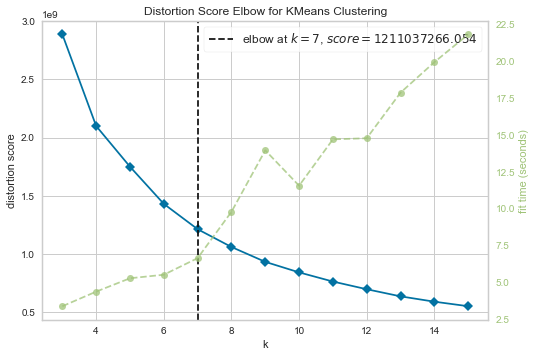

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

k_viz = KElbowVisualizer(KMeans(random_state= 42), k=(3, 16))
k_viz.fit(X)
k_viz.poof()

Silhouette Plot de KMeans avec 6 clusters
Silhouette score: 0.391


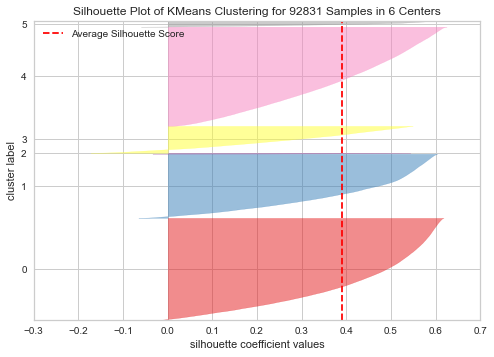

Silhouette Plot de KMeans avec 7 clusters
Silhouette score: 0.396


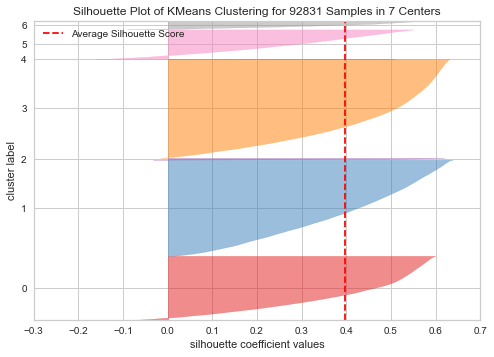

Silhouette Plot de KMeans avec 8 clusters
Silhouette score: 0.397


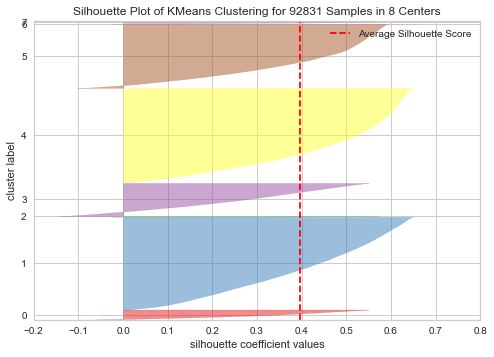

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer

for i in range(k_viz.elbow_value_ -1, k_viz.elbow_value_ +2):
    silh_viz = SilhouetteVisualizer(KMeans(i, random_state= 42))
    silh_viz.fit(X)

    print(f"Silhouette Plot de KMeans avec {i} clusters")
    print(f"Silhouette score: {np.round(silh_viz.silhouette_score_, 3)}")
    silh_viz.poof()

La méthode Elbow sur le KMeans met en évidence 7 clusters. 

L' utilisation de la méthode Silhouette avec 6, 7, 8 clusters montrent des graphiques uniformes. Je vais néanmoins garder 8 clusters car le silhouette score est le plus élevé (0.397) mais aussi car les bars sont plus bombées sur ce graphique que sur les autres.

Je vais maintenant confirmer l'hypothèse des 8 clusters avec un PCA.

In [68]:
kmean = KMeans(8, random_state= 42).fit(X)


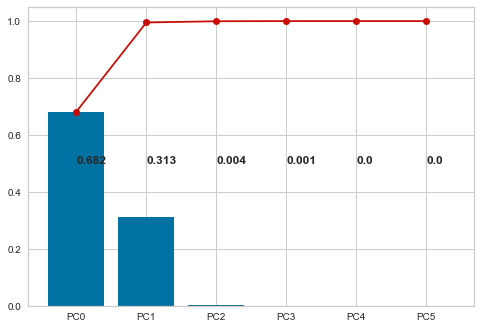

In [69]:
from sklearn.decomposition import PCA

components = 6

pca = PCA(n_components= components)
pca.fit(X)

X_pca = pd.DataFrame(pca.transform(X))

expl_var_ratio = pca.explained_variance_ratio_
var_cumsum = expl_var_ratio.cumsum()

plt.bar(["PC" + str(x) for x in range(len(expl_var_ratio))], expl_var_ratio)
plt.plot(["PC" + str(x) for x in range(len(var_cumsum))], var_cumsum, "ro-")

for num, evr in enumerate(expl_var_ratio):
    plt.text(num, 0.5, str(np.round(evr, 3)), fontweight= "bold")

plt.show()

La composante PC0 explique 100% des valeurs de la réduction. Je vais donc la garder comme composante de référence.

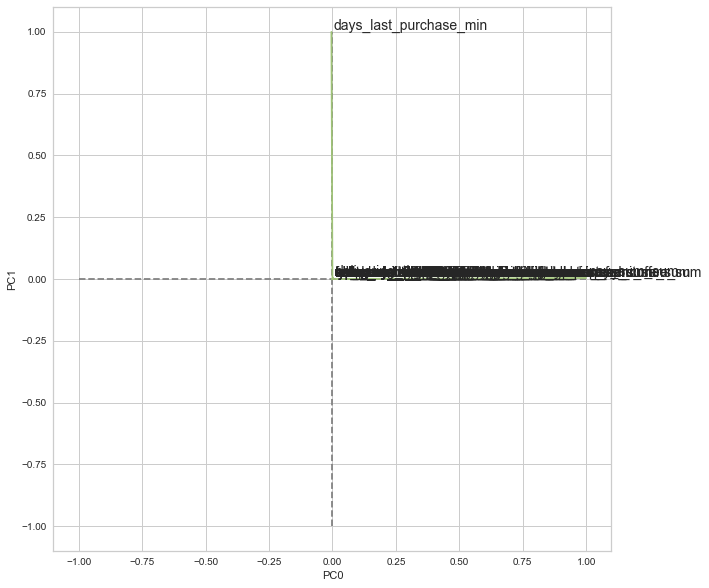

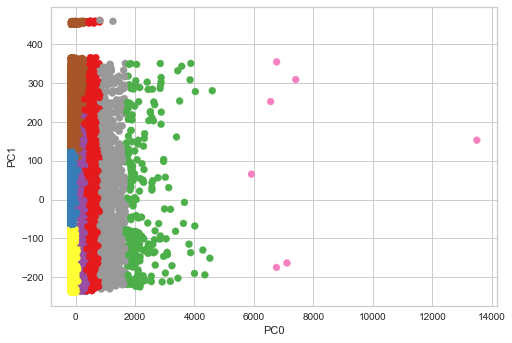

In [70]:
fig = plt.figure(figsize=(10, 10))
plt.plot([-1, 1], [0, 0], color= "grey", ls="--")
plt.plot([0, 0], [-1, 1], color= "grey", ls="--")

for i, (x, y) in enumerate(zip(pca.components_.T[:, 0], pca.components_.T[:, 1])):
    plt.plot([0, x], [0, y], color= "g", ls= "-")
    plt.text(x + 0.01, y + 0.01, X.columns[i], fontsize= 14)

plt.xlabel("PC0")
plt.ylabel("PC1")

plt.show()

plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c= kmean.labels_, cmap= "Set1")

plt.xlabel("PC0")
plt.ylabel("PC1")

plt.show()


Le KMeans suivi du PCA montre clairement 5 clusters distincts. Ils sont alignés le long de la composante principale "PC0". On peut aussi voir sur la composante "PC1" 3 groupes distincts. "PC1" explique la feature "customer_state" selon le cercle de corrélation.

Je vais maintenant lancer le script d'analyse pour avoir plus de détails pour chaque cluster.

In [71]:
datas["labels"] = kmean.labels_

In [73]:
# datas.to_csv("POLIST_13_kmean_datas.csv", index=False)